# ML 모델링

   ## 유통매장 수요량 예측

* 비즈니스 현황
    * 고객사는 A 유통회사의 a 매장 입니다.
    * a 매장에서 주력상품인 a01에 대한 재고 최적화를 위해 수요량을 예측하고자 합니다.
    * 최근 경쟁사의 매장이 가까운 거리에 오픈하였고, 유사한 상품에 대한 공격적인 마케팅을 펼치고 있습니다.
* 발주 최적화를 위한 수요량 예측
    * 일마감 이후, 발주량을 결정할 때, 예측된 수요량이 필요합니다.
    * 발주후 입고까지는 2일의 기간이 걸립니다.
    * 예를 들면
        * 2019년 6월 1일 저녁 10시 일마감 직후, 6월 3일의 수요량을 예측해야 합니다.
        * 예측된 수요량과 현 재고, 안전재고량 등을 감안하여 발주량은 결정되고,
        * 발주 수량은 6월3일 새벽에 매장에 입고되어 6월3일에 판매할 수 있습니다.
* 발주 최적화를 위한 수요량 예측 : 2일후의 판매량을 예측

![](https://www.artefact.com//wp-content/uploads/2021/08/GettyImages-1295864156-scaled.jpg)

# 1.환경준비

## (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) 함수 생성

### 1) 결과 시각화

In [2]:
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### 2) 잔차분석

In [3]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

### 3) 시계열분해 plot

In [4]:
def decomp_plot(decomp) :
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})
    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')
    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')
    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')
    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

## (3) Data Loading

In [5]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/retail_demand2.csv'
data = pd.read_csv(path)
data = data.loc[data['date'].between('2013-06-01', '2015-03-02')].reset_index(drop = True)
data

,date,item,sales,tot_sales,comp_sales
0,2013-06-01,28,124,1016,80
1,2013-06-02,28,139,1019,93
2,2013-06-03,28,77,676,65
3,2013-06-04,28,93,764,80
4,2013-06-05,28,117,818,80
...,...,...,...,...,...
635,2015-02-26,28,83,611,48
636,2015-02-27,28,91,696,74
637,2015-02-28,28,112,774,77
638,2015-03-01,28,113,967,75


* 변수 설명

    * date : 날짜
    * item : 상품코드 (여기서는 한가지 상품만 있음)
    * sales : A유통회사 a 매장 판매량 ==> target
    * tot_sales : A유통회사 전체 판매량
    * comp_sales : 인근에 위치한 B유통회사 b 매장 판매량

# 2.전처리

## (1) y 만들기

* 1일 후 수요량을 예측하려면, y를 어떻게 만들어야 할까요?

In [6]:
data['y'] = data['sales'].shift(-2)
display(data.head())
display(data.tail())

,date,item,sales,tot_sales,comp_sales,y
0,2013-06-01,28,124,1016,80,77.0
1,2013-06-02,28,139,1019,93,93.0
2,2013-06-03,28,77,676,65,117.0
3,2013-06-04,28,93,764,80,112.0
4,2013-06-05,28,117,818,80,127.0


,date,item,sales,tot_sales,comp_sales,y
635,2015-02-26,28,83,611,48,112.0
636,2015-02-27,28,91,696,74,113.0
637,2015-02-28,28,112,774,77,87.0
638,2015-03-01,28,113,967,75,NaN
639,2015-03-02,28,87,651,68,NaN


In [7]:
# 마지막 두 행은 삭제
data.dropna(axis = 0, inplace = True)
data.tail()

,date,item,sales,tot_sales,comp_sales,y
633,2015-02-24,28,66,603,71,83.0
634,2015-02-25,28,83,622,61,91.0
635,2015-02-26,28,83,611,48,112.0
636,2015-02-27,28,91,696,74,113.0
637,2015-02-28,28,112,774,77,87.0


## (2) Feature Engineering
* 필요한 변수 도출 : 최소 4개 이상
    * 날짜 요소
    * 시간 흐름
    * 시계열 데이터 분해


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638 entries, 0 to 637
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        638 non-null    object 
 1   item        638 non-null    int64  
 2   sales       638 non-null    int64  
 3   tot_sales   638 non-null    int64  
 4   comp_sales  638 non-null    int64  
 5   y           638 non-null    float64
dtypes: float64(1), int64(4), object(1)
memory usage: 34.9+ KB


### 1) 날짜 요소

In [11]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638 entries, 0 to 637
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        638 non-null    datetime64[ns]
 1   item        638 non-null    int64         
 2   sales       638 non-null    int64         
 3   tot_sales   638 non-null    int64         
 4   comp_sales  638 non-null    int64         
 5   y           638 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 34.9 KB


In [12]:
# 요일
data['weekday'] = data['date'].dt.weekday

In [15]:
# 계절
data['season'] = pd.cut(data['date'].dt.month, bins = [1,2,5,8,11,12]
                        , labels = ['Winter','Spring','Summer','Autumn','Winter']
                        , include_lowest= True, ordered = False)

In [16]:
data.head()

,date,item,sales,tot_sales,comp_sales,y,weekday,season
0,2013-06-01,28,124,1016,80,77.0,5,Summer
1,2013-06-02,28,139,1019,93,93.0,6,Summer
2,2013-06-03,28,77,676,65,117.0,0,Summer
3,2013-06-04,28,93,764,80,112.0,1,Summer
4,2013-06-05,28,117,818,80,127.0,2,Summer


### 2) 시간 흐름

In [17]:
# 전전날 대비 판매량 증감
data['sales_diff1'] = data['sales'].diff()

In [18]:
# y값 대비 1주일 전 판매량
data['sales_lag7'] = data['y'].shift(7)

In [19]:
# sales값 1주일 전 판매량 증감
data['sales_diff7'] = data['sales'].diff(7)

In [20]:
data.head()

,date,item,sales,tot_sales,comp_sales,y,weekday,season,sales_diff1,sales_lag7,sales_diff7
0,2013-06-01,28,124,1016,80,77.0,5,Summer,NaN,NaN,NaN
1,2013-06-02,28,139,1019,93,93.0,6,Summer,15.0,NaN,NaN
2,2013-06-03,28,77,676,65,117.0,0,Summer,-62.0,NaN,NaN
3,2013-06-04,28,93,764,80,112.0,1,Summer,16.0,NaN,NaN
4,2013-06-05,28,117,818,80,127.0,2,Summer,24.0,NaN,NaN


### 3) 시계열 데이터 분해

* seasonal 패턴 저장
    * period = 7

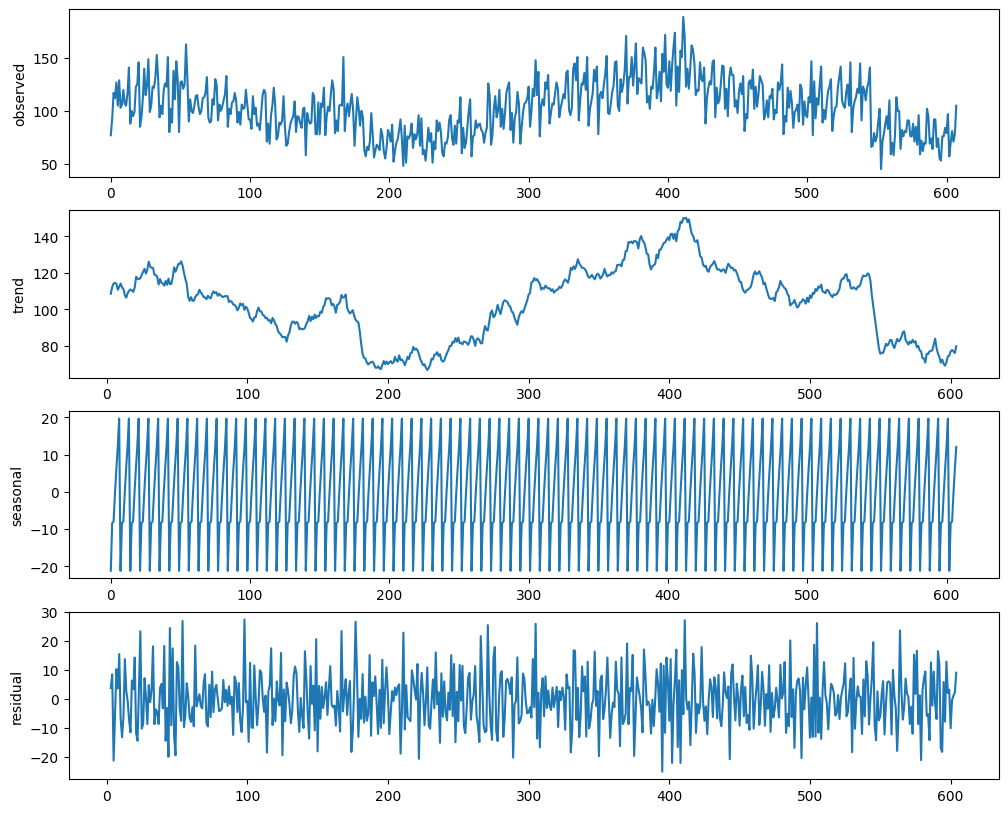

In [21]:
val_size = 30
decomp = sm.tsa.seasonal_decompose(data.y[:-val_size], model = 'additive', period = 7)
plt.figure(figsize=(12,10))
result = decomp_plot(decomp)

In [22]:
# 24개 주기 seasonal 데이터 붙이기
seasonal7 = result.seasonal[:7]

# 전체 데이터 건수 만큼 Seasonal 데이터 만들기
n = data.shape[0] // 7 + 1
seasonal_all = list(seasonal7) * n
seasonal_all[: data.shape[0]]

# data 셋에 붙이기
data['Seasonal7'] = seasonal_all[: data.shape[0]]
data.head(10)

,date,item,sales,tot_sales,comp_sales,y,weekday,season,sales_diff1,sales_lag7,sales_diff7,Seasonal7
0,2013-06-01,28,124,1016,80,77.0,5,Summer,NaN,NaN,NaN,-21.178927
1,2013-06-02,28,139,1019,93,93.0,6,Summer,15.0,NaN,NaN,-8.353346
2,2013-06-03,28,77,676,65,117.0,0,Summer,-62.0,NaN,NaN,-7.969625
3,2013-06-04,28,93,764,80,112.0,1,Summer,16.0,NaN,NaN,-0.389891
4,2013-06-05,28,117,818,80,127.0,2,Summer,24.0,NaN,NaN,6.178215
5,2013-06-06,28,112,881,71,105.0,3,Summer,-5.0,NaN,NaN,12.053631
6,2013-06-07,28,127,929,81,129.0,4,Summer,15.0,NaN,NaN,19.659943
7,2013-06-08,28,105,925,78,103.0,5,Summer,-22.0,77.0,-19.0,-21.178927
8,2013-06-09,28,129,998,95,106.0,6,Summer,24.0,93.0,-10.0,-8.353346
9,2013-06-10,28,103,710,74,120.0,0,Summer,-26.0,117.0,26.0,-7.969625


## (3) NaN 조치

In [23]:
data.isna().sum()

date           0
item           0
sales          0
tot_sales      0
comp_sales     0
y              0
weekday        0
season         0
sales_diff1    1
sales_lag7     7
sales_diff7    7
Seasonal7      0
dtype: int64

In [24]:
data = data.dropna(axis = 0)
data.reset_index(drop = True, inplace = True)

## (4) 가변수화(필요시)

In [25]:
# 요일 변수를 가변수화
data2 = pd.get_dummies(data, columns = ['weekday','season'], drop_first = True )
data2.head()

,date,item,sales,tot_sales,comp_sales,y,sales_diff1,sales_lag7,sales_diff7,Seasonal7,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,season_Spring,season_Summer,season_Winter
0,2013-06-08,28,105,925,78,103.0,-22.0,77.0,-19.0,-21.178927,0,0,0,0,1,0,0,1,0
1,2013-06-09,28,129,998,95,106.0,24.0,93.0,-10.0,-8.353346,0,0,0,0,0,1,0,1,0
2,2013-06-10,28,103,710,74,120.0,-26.0,117.0,26.0,-7.969625,0,0,0,0,0,0,0,1,0
3,2013-06-11,28,106,823,87,107.0,3.0,112.0,13.0,-0.389891,1,0,0,0,0,0,0,1,0
4,2013-06-12,28,120,813,88,105.0,14.0,127.0,3.0,6.178215,0,1,0,0,0,0,0,1,0


## (5) 데이터 분할

### 1) x, y 나누기

In [27]:
target = 'y'

x = data2.drop([target, 'date','item'], axis = 1)
y = data2.loc[:, target]

### 2) train, val 분할
* 최근 30일 데이터를 Validation Set으로 지정

In [28]:
val_size = 30
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = val_size, shuffle = False)

# 3.모델링
* 다양한 알고리즘 3개 이상을 이용하여 모델링을 수행하시오.
* 각 모델에 대해서 성능 평가를 수행하시오.
    * 검증 성능
    * 잔차 : ACF, PACF, 정규성, 정상성 검정
* 예측결과 시각화

## (1) 모델1

### 1) 학습 및 예측

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [31]:
params = { 'n_estimators':range(10,201,10)}
model1 = GridSearchCV(RandomForestRegressor(), params, cv = 3)
model1.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': range(10, 201, 10)})

In [33]:
model1.best_params_

{'n_estimators': 180}

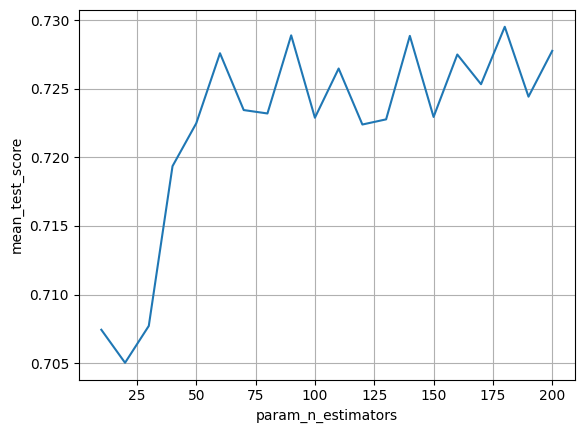

In [38]:
result = pd.DataFrame(model1.cv_results_)
result = result[['param_n_estimators','mean_test_score']]

sns.lineplot(x = 'param_n_estimators', y = 'mean_test_score', data = result )
plt.grid()
plt.show()

### 2) 평가
* 검증 평가


In [39]:
pred1 = model1.predict(x_val)

In [40]:
print('MAE :', mean_absolute_error(y_val, pred1))
print('MAPE:', mean_absolute_percentage_error(y_val, pred1))
print('R2  :', r2_score(y_val, pred1))

MAE : 8.28
MAPE: 0.08963180786635302
R2  : 0.38234038152172467


### 3) 결과 시각화

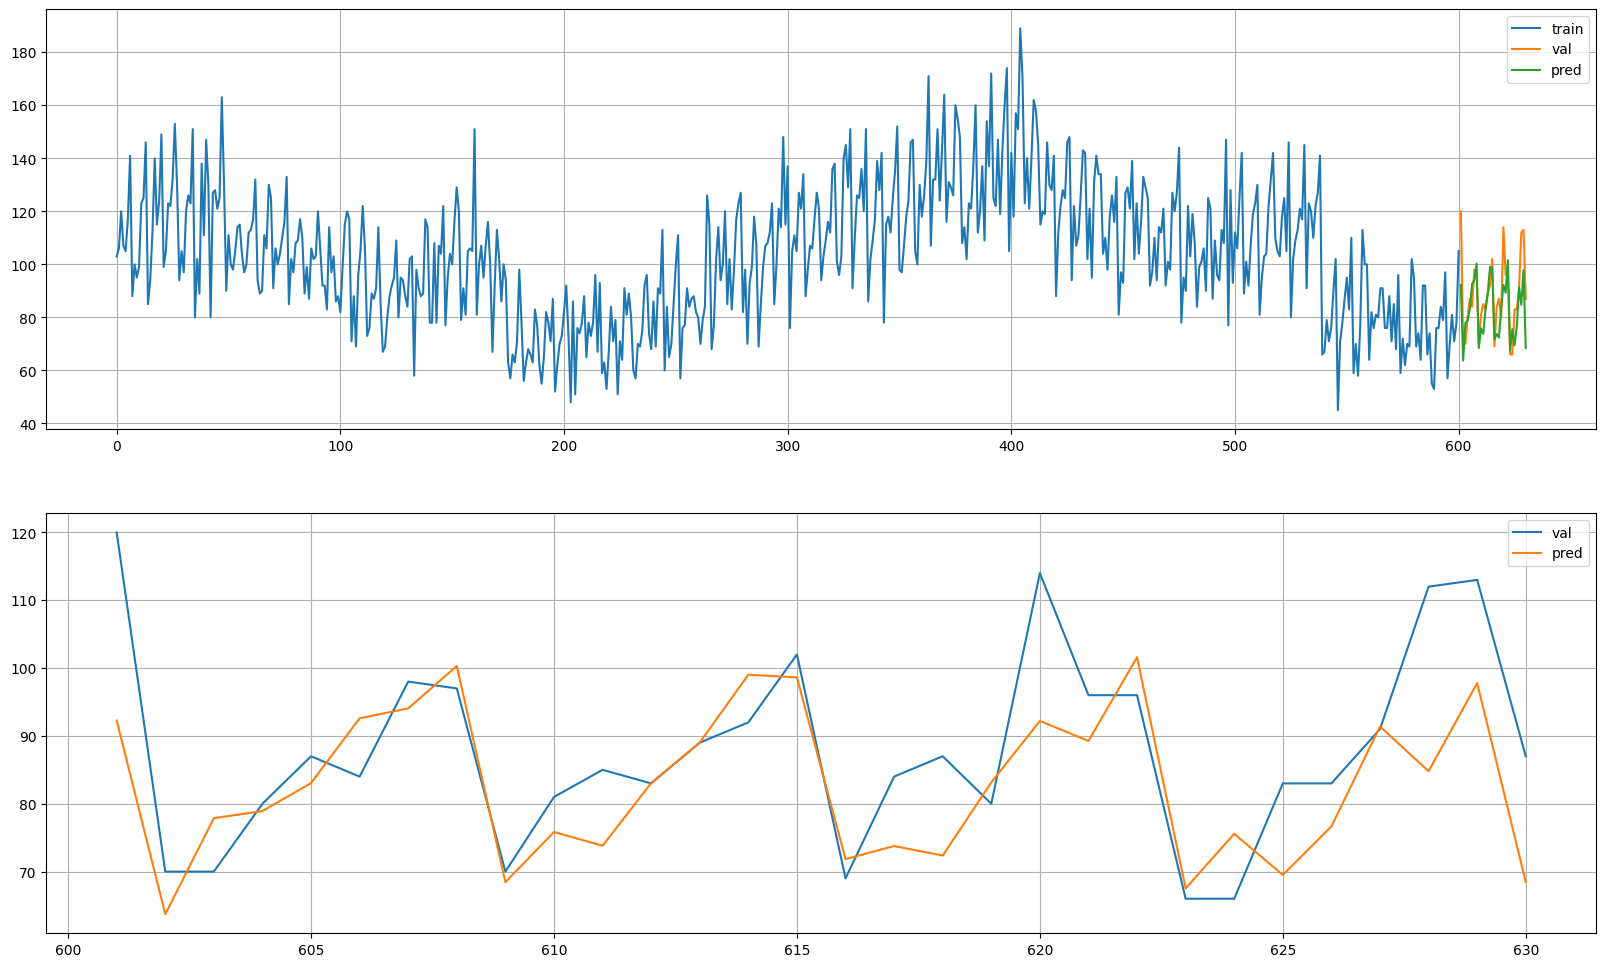

In [41]:
plot_model_result(y_train, y_val, pred1)

## (2) 모델2

### 1) 학습 및 예측

### 2) 평가
* 검증 평가


### 3) 결과 시각화

## (3) 모델3

In [42]:
from sklearn.linear_model import LinearRegression

In [43]:
model1 = LinearRegression()
model1.fit(x_train, y_train)

LinearRegression()

### 2) 예측

In [44]:
# 예측
pred = model1.predict(x_val)

## (3) 평가

### 1) 검증성능

In [45]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 8.549037275699478
MAPE: 0.09617653808955051
R2  : 0.4153213901586188


### 2) 결과 시각화

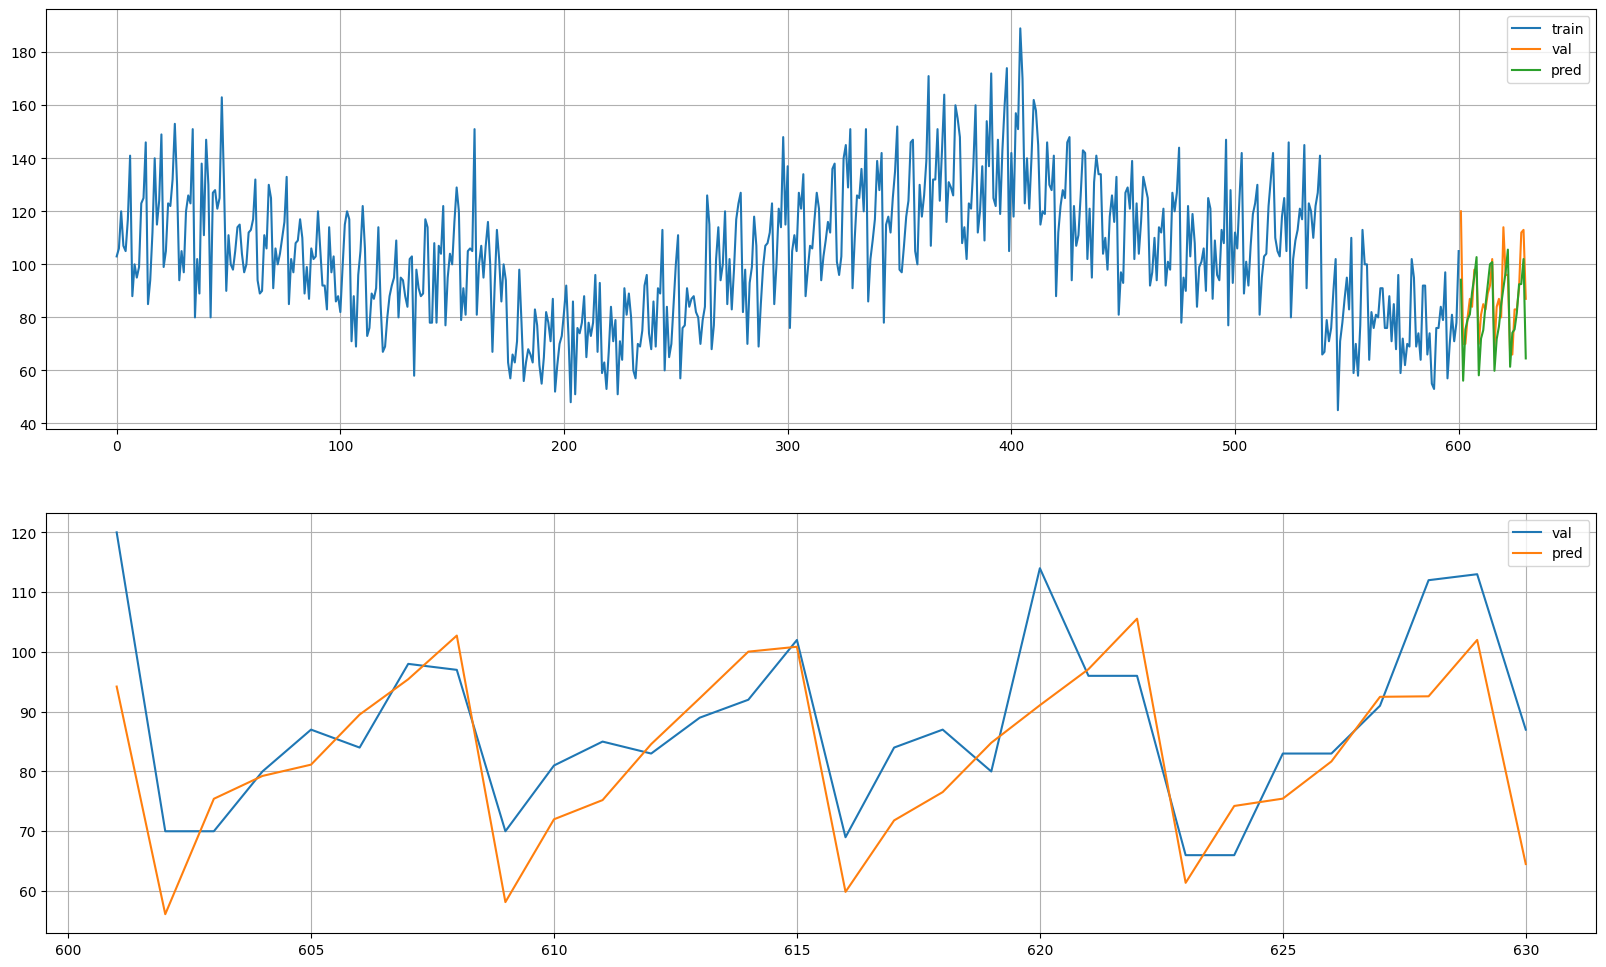

In [46]:
plot_model_result(y_train, y_val, pred)

# 4.데이터 저장

## (1) 예측결과 저장
* joblib을 이용하여
* 가장 성능이 좋았던 모델의 예측 결과를 저장합니다.

In [47]:
import joblib

joblib.dump( pred1, 'pred_32.pkl')

['pred_32.pkl']

## (2) 전처리 데이터 저장
* 2 - (4) 까지 실행된 데이터프레임 저장

In [48]:
joblib.dump(data2 , 'data_32.pkl')

['data_32.pkl']

**저장된 파일을 다운로드 받으세요.**
* 왼쪽 파일 탭 > 저장한 파일 오른쪽 클릭 > 다운로드